<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/solution/notebooks/named-entity-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named-Entity-Recognition in TensorFlow 2

This notebook contains code to do Named Entity Reconition in TensorFlow 2.

## Imports and Dependencies

TensorFlow Addons apparently has an implementation of CRF that is compatible with TF2 and tf.keras.

In [ ]:
# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow.keras as K
import tensorflow.keras.layers as L

# Python
import os
import string
import re
import random
import time

# Data Structures
import numpy as np
import pandas as pd
import json

# Image/Plotting
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode='Plain', color_scheme='LightBg', tb_offset=1) # Change to 'Verbose' mode for additional debugging

In [ ]:
# Note that '!' indicates a shell command rather than python code...

# French NER
# ID: 1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g" -O french_ner_dataset.txt && rm -rf /tmp/cookies.txt

# French Text
# ID: 1M26Gpca8Ug4YvRLxoUDDCjMBeJtojITY
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wDMLz9hTmfvPhkhCHTylbeAU6Utpkqb1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wDMLz9hTmfvPhkhCHTylbeAU6Utpkqb1" -O french_text.txt && rm -rf /tmp/cookies.txt

# Word Embedding Weights
# ID: 1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM" -O french_embedding_weights.npy && rm -rf /tmp/cookies.txt

# char_set.json
!wget -q https://raw.githubusercontent.com/ericburdett/named-entity-recognition/master/char_set.json

## Tokenization and Mapping

We need some way to tokenize our input sentences and map between our character
and integer representations.

Here, we will use both a word-level tokenization and a character-level
tokenization.

In [ ]:
DEFAULT_CHARS = ' !"#$%&\'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz|~£§¨«¬\xad' \
                '°²´·º»¼½¾ÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿłŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ‒–—†‡‰‹›₂₤℔⅓⅔⅕⅖⅗⅘⅙⅚⅛∆∇∫≠□♀♂✓ｆ'
# The default list of non-punctuation characters needed for the word beam search decoding algorithm
DEFAULT_NON_PUNCTUATION = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿ' \
                          'łŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ'

DEFAULT_PUNCTUATION = string.punctuation + '0123456789'

We need a corpus to know which words to include in our word-level tokenization.

Load in the text file containing french words.

In [ ]:
lines = open('french_text.txt', 'r', encoding='utf8').readlines()

french_words = []
for line in lines:
    french_words.extend(line.split())
french_words = ' '.join(french_words)

Word-Level Tokenization

Example:
* hello --> 1
* world --> 2

In [ ]:
class WordTokenizer:
    def __init__(self, corpus, word_chars, punctuation, lower=False):
        self.word_chars = word_chars
        self.punctuation = punctuation
        self.regex = r"[" + self.word_chars + r"]+|[^\s]" 

        words = self.split(corpus)
        all_words_list = words + list(punctuation)
        all_words_list_unique = list(set(all_words_list))
        all_words = [' '.join(all_words_list_unique)]

        self.total_tokens = len(all_words_list_unique) + 2 # +2 to account for 0 (reserved) and 1 (OOV)
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.total_tokens, filters='', lower=lower, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(all_words)

    def split(self, text):
        return re.findall(self.regex, text)

    def texts_to_sequences(self, text):
        words = self.split(text)
        return self.tokenizer.texts_to_sequences([' '.join(words)])
    
    def sequences_to_texts(self, sequences):
        return self.tokenizer.sequences_to_texts(sequences)

Character-Level Tokenization

Example:
* hello -> [8, 5, 12, 12, 15]
* world -> [23, 15, 18, 12, 4]

In [ ]:
class CharTokenizer:
    def __init__(self, chars: str = DEFAULT_CHARS, max_seq_size: int = 16):
        self.total_tokens = len(chars) + 2  # +2 to account for 0 (reserved) and 1 (OOV: Out-Of-Vocab)
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.total_tokens, filters='', lower=False,
                                                               char_level=True, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(chars)
        self.max_seq_size = max_seq_size

    def texts_to_sequences(self, texts: str):
        sequences = self.tokenizer.texts_to_sequences(texts)
        return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=self.max_seq_size, padding='post',
                                                             truncating='post')

    def sequences_to_texts(self, sequences: list):
        return self.tokenizer.sequences_to_texts(sequences)

Read in our NER dataset. Do some small preprocessing steps to include the start
of a record. (Currently the dataset is divided by records designated by the
'id' column). We want the model to be able to predict when a record starts and
ends. Thus, we are adding a 'Start' entity to every beginning word in a record.

Create dictionaries to map between entities and indices.

In [ ]:
df = pd.read_csv('french_ner_dataset.txt', sep='\t', names=['word', 'entity', 'id'], header=None)

entities = list(set(list(df['entity']))) + ['Start']
print('Possible Entities:', entities)

entity2idx = {}
idx2entity = {}

for index, entity in enumerate(entities):
    entity2idx[entity] = index
    idx2entity[index] = entity

Possible Entities: ['PrimaryName', 'Date', 'Place', 'Name', 'none', 'Age', 'Start']


Iterate through our entire dataset, tokenize everything and place the labels and the word-level and character-level tokenizations in their own separate tensors.

These tensors will be grouped by sentences (records). We do this to allow for
shuffling purposes. Shuffling tends to help the model converge quicker and not
get caught up with the particular order of the records. This is very important
since our model's RNNs are stateful.

In [ ]:
word_tokenizer = WordTokenizer(french_words, DEFAULT_NON_PUNCTUATION, DEFAULT_PUNCTUATION)
char_tokenizer = CharTokenizer(entities)

# We're using a pandas DataFrame, so convert to numpy format
data = df.values

sentences = []
sentences_chars = []
labels = []

sentence = []
sentence_chars = []
label = []
current_id = 0
for word, entity, id in data:
    if current_id != id and len(sentence) != 0:

        sentences.append(sentence)
        sentences_chars.append(sentence_chars)
        labels.append(label)

        sentence = []
        sentence_chars = []
        label = []

        current_id = id
        entity = 'Start'

    tokens = word_tokenizer.texts_to_sequences(word)[0]
    tokens_str = word_tokenizer.split(word)
    idx = entity2idx[entity]
    for token, token_str in zip(tokens, tokens_str):
        sentence.append(token)
        sentence_chars.append(char_tokenizer.texts_to_sequences(token_str)[0])
        label.append(idx)

if len(sentence) != 0:
    sentences.append(sentence)
    sentences_chars.append(sentence_chars)
    labels.append(label)

dataset_size = 0
for sentence in sentences:
    for word in sentence:
        dataset_size += 1

sentences = tf.ragged.constant(sentences)
sentences_chars = tf.ragged.constant(sentences_chars)
labels = tf.ragged.constant(labels)

Create the actual dataset grouped by sentences from the ragged tensors created
above. Then shuffle each iteration as we wanted and then flatten so that each
instance in the dataset corresponds to a word rather than a sentence of words.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))\
    .shuffle(150, reshuffle_each_iteration=True)\
    .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y, z)))

for word, chars, entity in dataset.take(5):
    print('Word:', word)
    print('Chars:', chars)
    print('Label:', entity)

print('Dataset Size:', dataset_size)

Word: tf.Tensor(24461, shape=(), dtype=int32)
Chars: tf.Tensor([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Label: tf.Tensor(6, shape=(), dtype=int32)
Word: tf.Tensor(13327, shape=(), dtype=int32)
Chars: tf.Tensor([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Label: tf.Tensor(6, shape=(), dtype=int32)
Word: tf.Tensor(36782, shape=(), dtype=int32)
Chars: tf.Tensor([2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Label: tf.Tensor(6, shape=(), dtype=int32)
Word: tf.Tensor(56, shape=(), dtype=int32)
Chars: tf.Tensor([5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Label: tf.Tensor(1, shape=(), dtype=int32)
Word: tf.Tensor(3223, shape=(), dtype=int32)
Chars: tf.Tensor([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Label: tf.Tensor(1, shape=(), dtype=int32)
Dataset Size: 18944


## Model Architecture

This is where we can build our model using the tf.keras high-level API

We subclass from tf.keras.Model and implement the *call* method. This is the *forward pass* of the neural network.

In [ ]:
reg = tf.keras.regularizers.L2(l2=0.00)

class NERModel(K.Model):
  def __init__(self, word_input_dim=25_000, word_output_dim=128, char_input_dim=197, char_output_dim=128, num_classes=8, embedding_weights=None, word_trainable=True):
    super(NERModel, self).__init__()

    self.word_embedding = L.Embedding(input_dim=word_input_dim, output_dim=char_output_dim, mask_zero=True, trainable=word_trainable, weights=embedding_weights)
    self.char_embedding = L.Embedding(input_dim=char_input_dim, output_dim=char_output_dim, mask_zero=True, trainable=True)

    self.char_conv1 = L.Conv1D(64, 3, padding='same')
    self.bn1 = L.BatchNormalization()
    self.relu1 = L.ReLU()
    self.char_conv2 = L.Conv1D(64, 3, padding='same')
    self.bn2 = L.BatchNormalization()
    self.relu2 = L.ReLU()
    self.mp1 = L.MaxPooling1D()
    self.char_conv3 = L.Conv1D(96, 3, padding='same')
    self.bn3 = L.BatchNormalization()
    self.relu3 = L.ReLU()
    self.mp2 = L.MaxPooling1D()
    self.char_conv4 = L.Conv1D(96, 3, padding='same')
    self.bn4 = L.BatchNormalization()
    self.relu4 = L.ReLU()
    self.mp3 = L.MaxPooling1D()
    self.char_conv5 = L.Conv1D(128, 3, padding='same')
    self.bn5 = L.BatchNormalization()
    self.relu5 = L.ReLU()
    self.mp4 = L.MaxPooling1D()

    self.gru1 = L.Bidirectional(L.GRU(128, return_sequences=True, stateful=True, dropout=0.5, kernel_regularizer=reg, batch_input_shape=(1, None)))
    self.gru2 = L.Bidirectional(L.GRU(128, return_sequences=True, stateful=True, dropout=0.5, kernel_regularizer=reg, batch_input_shape=(1, None)))

    self.dense = L.Dense(num_classes, kernel_regularizer=reg)

  def __call__(self, x_word, x_char, training=False, **kwargs):
    word_out = self.word_embedding(x_word)
    word_out = tf.expand_dims(word_out, 0)

    char_out = self.char_embedding(x_char)

    char_out = self.char_conv1(char_out)
    char_out = self.bn1(char_out)
    char_out = self.relu1(char_out)
    char_out = self.char_conv2(char_out)
    char_out = self.bn2(char_out)
    char_out = self.relu2(char_out)
    char_out = self.mp1(char_out)
    char_out = self.char_conv3(char_out)
    char_out = self.bn3(char_out)
    char_out = self.relu3(char_out)
    char_out = self.mp2(char_out)
    char_out = self.char_conv4(char_out)
    char_out = self.bn4(char_out)
    char_out = self.relu4(char_out)   
    char_out = self.mp3(char_out)
    char_out = self.char_conv5(char_out)
    char_out = self.bn5(char_out)
    char_out = self.relu5(char_out)   
    char_out = self.mp4(char_out)
    char_out = tf.transpose(char_out, perm=[1, 0, 2])

    out = tf.concat((word_out, char_out), axis=2)

    out = self.gru1(out)
    out = self.gru2(out)

    out = self.dense(out)

    out = tf.squeeze(out, 0)

    return out

Test it out to make sure we've set up our model properly.

The output shape should be (NUM_WORDS, NUM_CLASSES). Example: (41, 6)

The values along Axis=0 represents a word

The values along Axis=1 represents the probability distribution

In [ ]:
pretrained_embedding_weights = np.load('french_embedding_weights.npy')

dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))\
    .shuffle(150, reshuffle_each_iteration=True)\
    .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))

model = NERModel(word_input_dim=word_tokenizer.total_tokens, char_input_dim=char_tokenizer.total_tokens, num_classes=len(entity2idx), word_trainable=True)

for word, chars, entity in dataset.batch(5).take(1):
    results = model(word, chars, training=True)
    print('Shape of output from NER Model: ', results.shape)
    print('Probability Distribution for one word in the sentence: ', results[0])
    print('Predicted class for the word: ', tf.argmax(results[0]).numpy())

## Training Loop

Build our training loop and creating custom train_step and val_step functions.

GradientTape allows us to keep track of the losses and gradients for each pass through the network. Structuring our code this way makes it much easier for debugging purposes and for us to iterate through our design.

Notice the decorator *@tf.function*. This tells TensorFlow to create the computation graph from the python code and allows our model to run much faster. The *experimental_relax_shapes* parameter allows us to pass tensors with various sentence lengths without TensorFlow getting upset at us.

TensorFlow 2 also does some weird things with scope when it constructs the computation graph through a @tf.function annotation. Thus, if we use a more object oriented approach, we can avoid some of the nasty scope issues. See the following articles for more details:
* https://pgaleone.eu/tensorflow/tf.function/2019/03/21/dissecting-tf-function-part-1/
* https://pgaleone.eu/tensorflow/tf.function/2019/04/03/dissecting-tf-function-part-2/


In [ ]:
class Train:
    def __init__(self):
        # How many times through the training set should we go?
        self.epochs = 5
        self.batch_size = 128
        self.num_classes = len(idx2entity)

        # Break up dataset into training/validation
        dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))
        dataset_size = dataset.cardinality().numpy()
        self.train_dataset_size = int(dataset_size * 0.8)
        self.val_dataset_size = dataset_size - self.train_dataset_size

        self.train_dataset = dataset.take(self.train_dataset_size)\
            .shuffle(self.train_dataset_size, reshuffle_each_iteration=True)\
            .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))\
            .batch(self.batch_size, drop_remainder=False)
        self.val_dataset = dataset.skip(self.train_dataset_size)\
            .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))\
            .batch(self.batch_size, drop_remainder=False)

        self.train_dataset_size = 0
        for _, _, _ in self.train_dataset:
            self.train_dataset_size += 1

        self.val_dataset_size = 0
        for _, _, _ in self.val_dataset:
            self.val_dataset_size += 1

        embedding_weights = [np.load('french_embedding_weights.npy')]

        # Create our model
        self.model = NERModel(word_input_dim=word_tokenizer.total_tokens,
                              char_input_dim=char_tokenizer.total_tokens,
                              num_classes=self.num_classes,
                              embedding_weights=embedding_weights,
                              word_trainable=False)

        # Use CrossEntropy for our loss function and Adam for our optimizer
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
        # self.loss_fn = self.model.crf.loss
        self.optimizer = K.optimizers.Adam(learning_rate=2e-4)

        # Metrics to track our performance
        self.train_pred_loss = tf.keras.metrics.Mean(name='train_pred_loss')
        self.train_reg_loss = tf.keras.metrics.Mean(name='train_reg_loss')
        self.val_pred_loss = tf.keras.metrics.Mean(name='val_pred_loss')
        self.val_reg_loss = tf.keras.metrics.Mean(name='val_reg_loss')

    @tf.function(experimental_relax_shapes=True)
    def train_step(self, words, chars, labels):
        with tf.GradientTape() as tape:
            # Make a prediction, calculate the loss
            predictions = self.model(words, chars, training=True)
            # pred_loss = self.loss_fn(labels, predictions)
            pred_loss = self.loss_fn(tf.one_hot(labels, self.num_classes), predictions)
            reg_loss = tf.reduce_sum(self.model.losses)
            loss = pred_loss + reg_loss

        # Obtain gradients from GradientTape
        gradients = tape.gradient(loss, self.model.trainable_variables)

        # Propagate loss back through the network and take a step with the optimizer  
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_pred_loss(pred_loss)
        self.train_reg_loss(reg_loss)

        return predictions

    @tf.function(experimental_relax_shapes=True)
    def validation_step(self, words, chars, labels):
        # Make a prediction and calculate the loss
        predictions = self.model(words, chars, training=False)
        # pred_loss = self.loss_fn(labels, predictions)
        pred_loss = self.loss_fn(tf.one_hot(labels, self.num_classes), predictions)
        reg_loss = tf.reduce_sum(self.model.losses)
        loss = pred_loss + reg_loss

        self.val_pred_loss(pred_loss)
        self.val_reg_loss(reg_loss)

        return predictions

    def __call__(self):
        # Variables to keep track of our progress through the entire training process
        # Used below when we create our graphs
        try:
            train_losses, val_losses = [], []
            train_precisions, val_precisions = [], []
            train_recalls, val_recalls = [], []
            train_f1s, val_f1s = [], []

            for epoch in range(self.epochs):
                # Reset Metrics for another epoch
                self.train_pred_loss.reset_states()
                self.train_reg_loss.reset_states()
                self.val_pred_loss.reset_states()
                self.val_reg_loss.reset_states()

                # Training Loop
                y_pred = []
                y_true = []
                train_loop = tqdm(total=self.train_dataset_size, position=0, leave=True)
                for words, chars, labels in self.train_dataset:
                    # One training iteration
                    output = self.train_step(words, chars, labels)

                    predictions = tf.argmax(output, 1)
                    y_pred.extend(predictions.numpy())
                    y_true.extend(labels.numpy())

                    train_loop.set_description('Train - Epoch: {}, PredLoss: {:.4f}, RegLoss: {:.4f}'.format(
                    epoch, self.train_pred_loss.result(), self.train_reg_loss.result()))
                    train_loop.update(1)
                train_loop.close()

                precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
                print('Train - Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(precision, recall, f1))
                time.sleep(0.5)

                train_losses.append(self.train_pred_loss.result() + self.train_reg_loss.result())
                train_precisions.append(precision)
                train_recalls.append(recall)
                train_f1s.append(f1)

                self.model.reset_states()

                # Validation Loop
                y_pred = []
                y_true = []
                val_loop = tqdm(total=self.val_dataset_size, position=0, leave=True)
                for words, chars, labels in self.val_dataset:
                    # One validation iteration
                    output = self.validation_step(words, chars, labels)
                    predictions = tf.argmax(output, 1)

                    y_pred.extend(predictions.numpy())
                    y_true.extend(labels.numpy()) 

                    val_loop.set_description('Val  - Epoch: {}, PredLoss: {:.4f}, RegLoss: {:.4f}'.format(
                    epoch, self.val_pred_loss.result(), self.val_reg_loss.result()))
                    val_loop.update(1)
                val_loop.close()

                self.model.reset_states()

                precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
                print('Val   - Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(precision, recall, f1))
                time.sleep(0.5)

                val_losses.append(self.val_pred_loss.result() + self.val_reg_loss.result())
                val_precisions.append(precision)
                val_recalls.append(recall)
                val_f1s.append(f1)

        except:
            __ITB__()
        finally:
            return self.model, (train_losses, val_losses), (train_precisions, val_precisions), (train_recalls, val_recalls), (train_f1s, val_f1s)

In [ ]:
try:
  train = Train()
  model, losses, precisions, recalls, f1s = train()
except:
  __ITB__()

Train - Epoch: 0, PredLoss: 1.1115, RegLoss: 0.0000: 100%|██████████| 115/115 [00:32<00:00,  3.49it/s]


Train - Precision: 0.6014, Recall: 0.3602, F1: 0.4131


Val  - Epoch: 0, PredLoss: 0.8851, RegLoss: 0.0000: 100%|██████████| 34/34 [00:03<00:00, 11.19it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val   - Precision: 0.7618, Recall: 0.5559, F1: 0.5917


Train - Epoch: 1, PredLoss: 0.7573, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.11it/s]


Train - Precision: 0.7685, Recall: 0.6707, F1: 0.7054


Val  - Epoch: 1, PredLoss: 0.7996, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.23it/s]


Val   - Precision: 0.7495, Recall: 0.6328, F1: 0.6784


Train - Epoch: 2, PredLoss: 0.6714, RegLoss: 0.0000: 100%|██████████| 115/115 [00:27<00:00,  4.25it/s]


Train - Precision: 0.9151, Recall: 0.7648, F1: 0.8034


Val  - Epoch: 2, PredLoss: 0.7732, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.10it/s]


Val   - Precision: 0.9040, Recall: 0.6512, F1: 0.7031


Train - Epoch: 3, PredLoss: 0.6286, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.28it/s]


Train - Precision: 0.9345, Recall: 0.8414, F1: 0.8794


Val  - Epoch: 3, PredLoss: 0.7444, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 23.04it/s]


Val   - Precision: 0.8743, Recall: 0.7466, F1: 0.7864


Train - Epoch: 4, PredLoss: 0.5995, RegLoss: 0.0000: 100%|██████████| 115/115 [00:26<00:00,  4.41it/s]


Train - Precision: 0.9463, Recall: 0.8917, F1: 0.9169


Val  - Epoch: 4, PredLoss: 0.7295, RegLoss: 0.0000: 100%|██████████| 34/34 [00:01<00:00, 24.04it/s]


Val   - Precision: 0.9059, Recall: 0.7402, F1: 0.7980


## Results

Show how our model did throughout the training process.

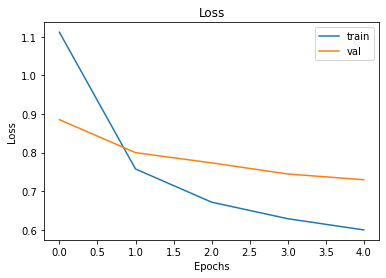

Final Validation Loss: 0.7295


In [ ]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses[0], label='train')
plt.plot(losses[1], label='val')
plt.legend()
plt.show()
print('Final Validation Loss: {:.4f}'.format(losses[1][-1]))

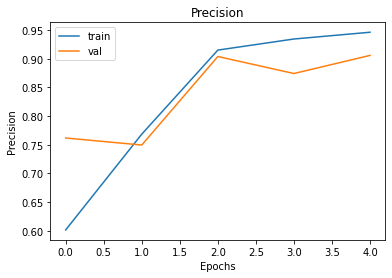

Final Validation Precision: 90.59%


In [ ]:
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(precisions[0], label='train')
plt.plot(precisions[1], label='val')
plt.legend()
plt.show()
print('Final Validation Precision: {:.2f}%'.format(precisions[1][-1] * 100))

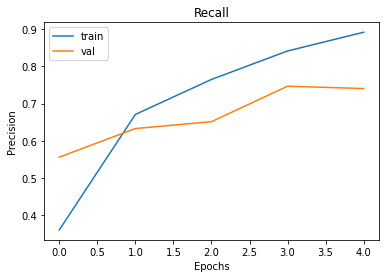

Final Validation Recall: 74.02%


In [ ]:
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(recalls[0], label='train')
plt.plot(recalls[1], label='val')
plt.legend()
plt.show()
print('Final Validation Recall: {:.2f}%'.format(recalls[1][-1] * 100))

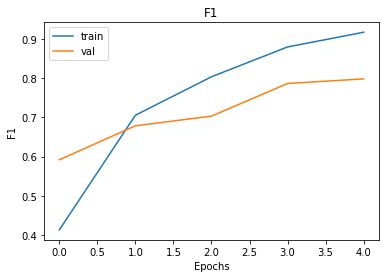

Final Validation F1: 79.80%


In [ ]:
plt.title('F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.plot(f1s[0], label='train')
plt.plot(f1s[1], label='val')
plt.legend()
plt.show()
print('Final Validation F1: {:.2f}%'.format(f1s[1][-1] * 100))

## Examples and Confusion Matrix

* Show the final confusion matrix on the validation set.
* Show a couple examples of the model classifying text.

In [ ]:
sentence_size = 200

batch_size = 200

dataset = tf.data.Dataset.from_tensor_slices((sentences, sentences_chars, labels))

dataset_size = dataset.cardinality().numpy()
train_dataset_size = int(dataset_size * 0.8)
val_dataset_size = dataset_size - train_dataset_size

val_dataset = dataset.skip(train_dataset_size)\
    .shuffle(150, reshuffle_each_iteration=True)\
    .take(sentence_size)\
    .flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices((x, y.to_tensor(), z)))\
    .batch(batch_size)

y_true = []
y_pred = []

for index, (word, char, label) in enumerate(val_dataset):
    output = model(word, char, training=False)
    prediction = tf.squeeze(tf.argmax(output, 1)).numpy()
    y_pred.extend(prediction)
    label = tf.squeeze(label).numpy()
    y_true.extend(label)

    word = np.expand_dims(word.numpy(), 1)
    str_words = word_tokenizer.sequences_to_texts(word)

    for word, pred, actual in zip(str_words, prediction, label):
        pred = idx2entity[pred]
        actual = idx2entity[actual]
        print('Word: {} - Prediction: {} - Actual: {}'.format(word, pred, actual))

Word: Le - Prediction: none - Actual: Start
Word: trente - Prediction: none - Actual: Date
Word: un - Prediction: none - Actual: Date
Word: décembre - Prediction: Date - Actual: Date
Word: mil - Prediction: Date - Actual: Date
Word: neuf - Prediction: Date - Actual: Date
Word: cent - Prediction: Date - Actual: Date
Word: à - Prediction: none - Actual: none
Word: minuit - Prediction: none - Actual: none
Word: nous - Prediction: none - Actual: none
Word: Bonnefond - Prediction: Name - Actual: Name
Word: Francisque - Prediction: none - Actual: Name
Word: , - Prediction: none - Actual: Name
Word: maire - Prediction: none - Actual: none
Word: et - Prediction: none - Actual: none
Word: officier - Prediction: none - Actual: none
Word: de - Prediction: none - Actual: none
Word: l - Prediction: none - Actual: none
Word: ' - Prediction: none - Actual: none
Word: etat - Prediction: none - Actual: none
Word: civil - Prediction: none - Actual: none
Word: de - Prediction: none - Actual: none
Word: l

Use sklearn to create the confusion matrix from the actual/predicted values

In [ ]:
def classification_report(y_true, y_pred, labels):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)

    print('|{:^15}|{:^12}|{:^12}|{:^12}|{:^12}|'.format('Class Label', 'Precision', 'Recall', 'F1', 'Support'))

    for p, r, f, s, label in zip(precision, recall, f1, support, labels):
        print('{:-<69}'.format(''))
        print('|{:^15}|{:^12.4f}|{:^12.4f}|{:^12.4f}|{:^12}|'.format(label, p, r, f, s))
    print('{:-<69}'.format(''))
    print('|{:^15}|{:^12.4f}|{:^12.4f}|{:^12.4f}|{:^12}|'.format('TOTAL', np.mean(precision), np.mean(recall), np.mean(f1), ''))
    print('{:-<69}'.format(''))


Print the Heatmap and convert the index class labels back to their original
text representation.

Text(123.0, 0.5, 'Actual')

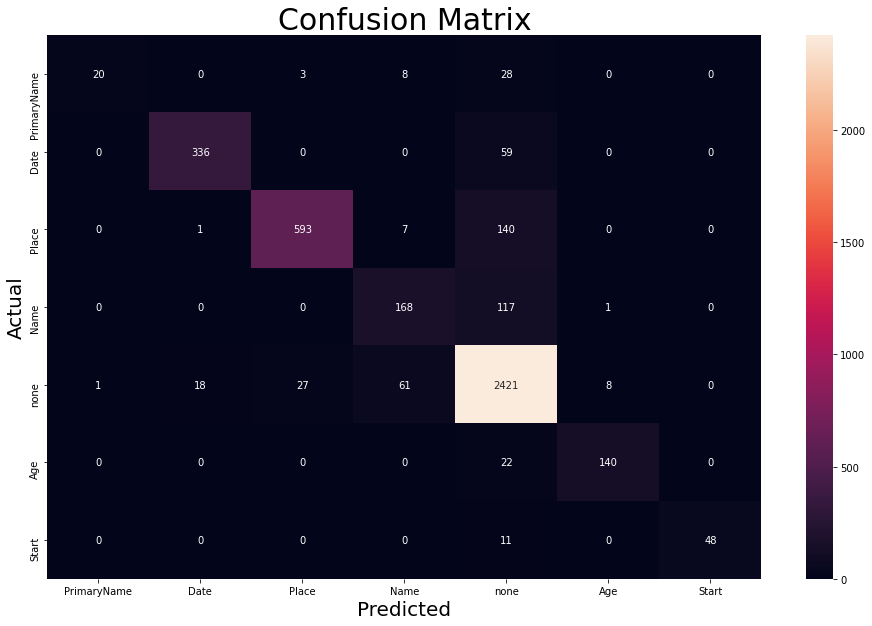

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred)

class_labels = [e for e in entity2idx]

plt.figure(figsize = (16, 10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix', fontdict={'fontsize': 30})
plt.xlabel('Predicted', fontdict={'fontsize': 20})
plt.ylabel('Actual', fontdict={'fontsize': 20})

In [ ]:
classification_report(y_true, y_pred, class_labels)

|  Class Label  | Precision  |   Recall   |     F1     |  Support   |
---------------------------------------------------------------------
|  PrimaryName  |   0.9524   |   0.3390   |   0.5000   |     59     |
---------------------------------------------------------------------
|     Date      |   0.9465   |   0.8506   |   0.8960   |    395     |
---------------------------------------------------------------------
|     Place     |   0.9518   |   0.8003   |   0.8695   |    741     |
---------------------------------------------------------------------
|     Name      |   0.6885   |   0.5874   |   0.6340   |    286     |
---------------------------------------------------------------------
|     none      |   0.8653   |   0.9547   |   0.9078   |    2536    |
---------------------------------------------------------------------
|      Age      |   0.9396   |   0.8642   |   0.9003   |    162     |
---------------------------------------------------------------------
|     Start     |   